In [1]:
import os
import sys

import torch
import torch.optim as optim
import os.path as osp

sys.path.append(os.path.abspath(".."))

In [2]:
from CellGraphX.configs.config import Config

In [3]:
from CellGraphX.training.trainer import Trainer

In [4]:
from CellGraphX.configs.config import Config
from CellGraphX.data.data_loader import data_loader, edge_weight_dict_loader
from CellGraphX.evaluation.tsne_vis import TSNE_vis
from CellGraphX.models.model import model_builder
from CellGraphX.training.optimizer import build_optimizer

/nfs/research/icortes/ysong/anaconda3/envs/pyg_gpu/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.sparse import csr_matrix, issparse


In [5]:
# Load configuration
print("Loading configuration...", flush=True)

config = Config()
# Initialize the model
print("Initializing model...", flush=True)
model = model_builder(config=config.model)

Loading configuration...
Initializing model...


In [6]:
model

HeteroGNN(
  (convs): ModuleList(
    (0-1): 2 x HeteroConv(num_relations=4)
  )
  (lin): Linear(64, 24, bias=True)
)

In [7]:
config

In [8]:
data_loader

<function CellGraphX.data.data_loader.data_loader(config)>

In [9]:
# Prepare the dataset and dataloaders
print("Loading data...")

Loading data...


In [10]:
data = data_loader(config=config.data)

Loading data from /nfs/research/irene/ysong/RESULTS/GeneCellType/GeneSpectra/MTG/CellGraphX/CellGraphX/data/mtg_all_sp_wilcox_data_with_og_ct_name.pt ...


/nfs/research/irene/ysong/RESULTS/GeneCellType/GeneSpectra/MTG/CellGraphX/CellGraphX/data/data_loader.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(

Split train val and test species
This is the HeteroData you are working with:
HeteroData(
  species_origin_index={
    0='H.sapiens',
    1='H.sapiens',
    2='H.sapiens',
    3='H.sapiens',
    4='H.sapiens',
    5='H.sapiens',
    6='H.sapiens',
    7='H.sapiens',
    8='H.sapiens',
    9='H.sapiens',
    10='H.sapiens',
    11='H.sapiens',
    12='H.sapiens',
    13='H.sapiens',
    14='H.sapiens',
    15='H.sapiens',
    16='H.sapiens',
    17='H.sapiens',
    18='H.sapiens',
    19='H.sapiens',
    20='H.sapiens',
    21='H.sapiens',
    22='H.sapiens',
    23='H.sapiens',
    24='M.mulatta',
    25='M.mulatta',
    26='M.mulatta',
    27='M.mulatta',
    28='M.mulatta',
    29='M.mulatta',
    30='M.mulatta',
    31='M.mulatta',
    32='M.mulatta',
    33='M.mulatta',
    34='M.mulatta',
    35='M.mulatta',
    36='M.mulatta',
    37='M.mulatta',
    38='M.mulatta',
    39='M.mulatta',
    40='M.mulatta',
    41='M.mulatta',
    42='M.mulatta',
    43='M.mulatta',
    44='M.mulat

In [11]:
data['cell_type'].val_mask

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [12]:
edge_weight_dict = edge_weight_dict_loader(data) if config.model.edge_weight else None

# Optimizer and learning rate scheduler
optimizer = build_optimizer(model, config.training)

# Scheduler (optional, for learning rate decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# Initialize the trainer with the model, data, optimizer, and config

In [13]:
edge_weight_dict

{('gene',
  'is_wilcox_marker_of',
  'cell_type'): tensor([4.0142, 4.0404, 4.0512,  ..., 6.7956, 7.1142, 7.1893]),
 ('cell_type',
  'rev_is_wilcox_marker_of',
  'gene'): tensor([4.0142, 4.0404, 4.0512,  ..., 6.7956, 7.1142, 7.1893])}

In [14]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)

In [15]:
scheduler

In [16]:
print("Initializing trainer...", flush=True)
trainer = Trainer(
    model=model,
    data=data,
    scheduler=scheduler,
    config=config,
    edge_weight_dict=edge_weight_dict,
    # optimizer, loss func, logdir build from config
)

Initializing trainer...


In [17]:
trainer

In [18]:
# Start the training
print("Starting training...", flush=True)
trainer.train(epochs=config.training.num_epochs)

print("Training completed with model saved.", flush=True)

Starting training...


2025-08-27 14:09:32,650 - INFO - Epoch 1/10
/nfs/research/icortes/ysong/anaconda3/envs/pyg_gpu/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
2025-08-27 14:10:20,656 - INFO - Train Loss: 118.9376 | Train Acc: 0.0417 | Val Acc: 0.0417 | Test Acc: 0.0417
2025-08-27 14:10:21,173 - INFO - Checkpoint saved to ./logs/best.pt
2025-08-27 14:10:21,740 - INFO - Checkpoint saved to ./logs/latest.pt
2025-08-27 14:10:21,742 - INFO - Epoch 2/10
2025-08-27 14:11:12,244 - INFO - Train Loss: 62.0057 | Train Acc: 0.0833 | Val Acc: 0.0417 | Test Acc: 0.0417
2025-08-27 14:11:12,715 - INFO - 

Training completed with model saved.


In [19]:
# t-SNE visualization
vis = TSNE_vis(model_path=f"{trainer.log_dir}/best.pt", data=data)

In [20]:
vis.model_path

'./logs/best.pt'

In [21]:
config = Config()
print("Initializing model...", flush=True)
model = model_builder(config=config.model)

Initializing model...


In [22]:
model

HeteroGNN(
  (convs): ModuleList(
    (0-1): 2 x HeteroConv(num_relations=4)
  )
  (lin): Linear(64, 24, bias=True)
)

In [23]:
print("Loading trainned model state dict...", flush=True)
if osp.isfile(vis.model_path):
    print(f"Loading model from {vis.model_path}")
else:
    raise FileNotFoundError(f"No model file found at {vis.model_path}")

Loading trainned model state dict...
Loading model from ./logs/best.pt


In [24]:
model.load_state_dict(
    torch.load(vis.model_path, map_location=torch.device("cpu"))["model_state_dict"]
)

/tmp/ipykernel_2029954/319233240.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(vis.model_path, map_location=torch.device("cpu"))["model_state_dict"]


<All keys matched successfully>

In [25]:
model.convs[0].parameters()

<generator object Module.parameters at 0x7f5269518f20>

Initializing model...
Loading trainned model state dict...
Loading model from ./logs/best.pt


/nfs/research/irene/ysong/RESULTS/GeneCellType/GeneSpectra/MTG/CellGraphX/CellGraphX/evaluation/tsne_vis.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(self

Performing t-SNE ...
Prepare species labels as shapes ...
Prepare cell type labels as colors ...
plotting ...


FileNotFoundError: [Errno 2] No such file or directory: '/nfs/research/irene/ysong/RESULTS/GeneCellType/GeneSpectra/MTG/CellGraphX/notebooks/logs/tsne_plot.png/tsne_plot_embed_5_species_ct_name_graphconv.png'

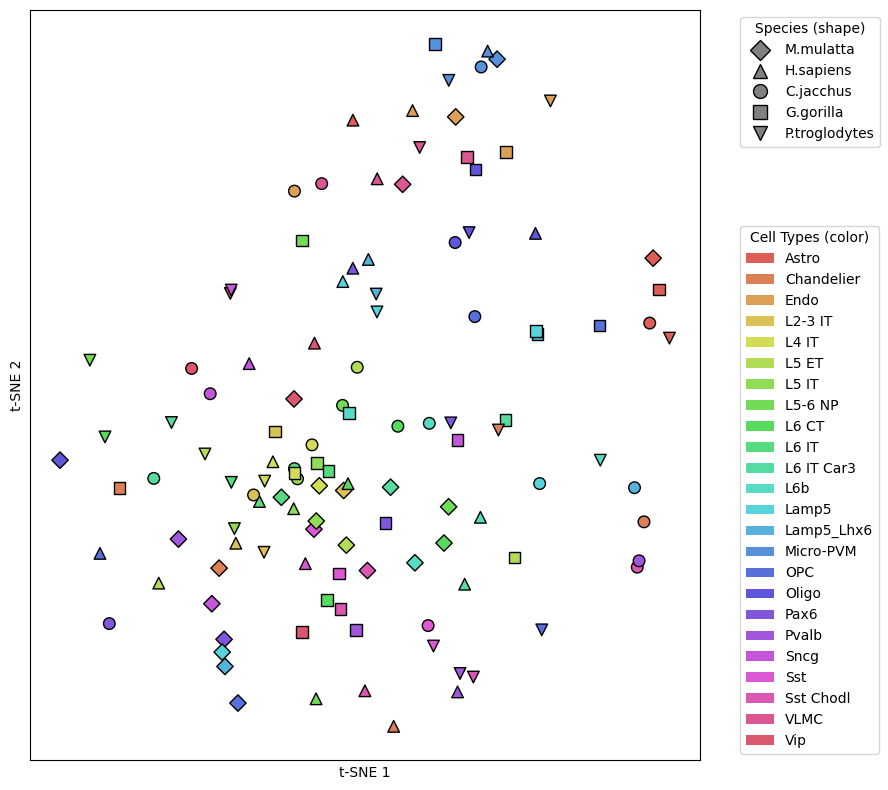

In [27]:
vis.plot_tsne(
        vis.get_tsne_embed(vis.load_model()),
        out_path=f"{trainer.log_dir}/tsne_plot.png",
    )